In [1]:
import pandas as pd
import numpy as np
import SVARIV
from tqdm import tqdm

# Load the data

In [2]:
#parameters 
p = 24 #lags
n = 3 #endog variables
nvar = 1 #test over the first one

In [3]:
X = pd.read_excel('./data/Oil/Data.xls', header=None)
X = np.concatenate([np.array([X[j].shift(i) for j in range(n)]).T for i in range(1, p+1)], axis=1)
X = X[p:, :] 
X = np.concatenate([np.ones((len(X),1)), X], axis=1)
Z = pd.read_excel('./data/Oil/ExtIV.xls', header=None).values[p:,:]
Y = pd.read_excel('./data/Oil/Data.xls', header=None).values[p:,:]

# ols estimation

In [4]:
ols_est = SVARIV.ols(Y, X)
eta = ols_est['errors']

Get the $\hat{W}$, wald and $\hat{\Gamma}$ using the independent variables, the instrument, the errors and the parameters. You can use help to know the function

In [5]:
help(SVARIV.get_gamma_wald)

Help on function get_gamma_wald in module SVARIV:

get_gamma_wald(X, Z, eta, p, n, nvar)
    Input:
        X = matrix of exogenous variables for ols estimation (np.array) 
        Z = matrix or vector of exog instruments (np.array)
        eta = matrix of errors (np.array)
        p = # of lags (scalar)
        n = # of endog (scalar)
        nvar = number of the endog variable to be use in the test
    output:
        WHat, wald, Gamma_hat



In [6]:
#this is the test of Wald and Gamma_hat (replication)
WHat, wald, Gamma_hat = SVARIV.get_gamma_wald(X, Z, eta, p, n, nvar)
print('Gamma_hat estimated: ')
print(Gamma_hat)
print('Wald estimated: {}'.format(wald))

Gamma_hat estimated: 
[[ 3.11805486]
 [ 0.11519854]
 [-0.43655489]]
Wald estimated: 4.398794075970551


# Impulse response

Using the $\hat{\beta}$ of the model you an estimate the impulse reponse. In this case, the function allow a covariance matrix of errors or $\hat{\Gamma}$. It will recoginze which one it is with the size of the matrix. See help of the function.


In [7]:
help(SVARIV.irf_lineal_cholesky)

Help on function irf_lineal_cholesky in module SVARIV:

irf_lineal_cholesky(betas, S, periods=21, normalize=True, cumulative=True)
    Input:
        betas = array in the order of the model (np.array) no constant 
                with n rows = number of endog variables, in the paper betas=A
        S = is a covariance matrix (np.array)
            if S has shape nx1 it will asume that S = Gamma_hat
        normalize=True will normalize to the shock to be 1 default=True
        cumulative=True will accumulate the irf response default=True
        periods = scalar with the number of periods to use in the irf default=21
    Output:
        irf = matrix of irf (np.array) with all irf for all endog variables
    Notice the shock is always over the first variable.



Recover the parameters of the estimation
Then take out the constants for every equation.
Get the covariance matrix


In [8]:
betas = ols_est['betas_hat'].T # A with constant
betas_lag = betas[:,1:] # A without constant
omega = (ols_est['errors'].T @ ols_est['errors']) / len(ols_est['errors']) #covar matrix errors

#Puntual estimation
# irf with cholesky decomposition
irf_chol = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=False)
irf_chol_cum = SVARIV.irf_lineal_cholesky(betas_lag, omega, cumulative=True)

# irf with Gamma_hat
irf_gamma = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=False)
irf_gamma_cum = SVARIV.irf_lineal_cholesky(betas_lag, Gamma_hat, cumulative=True)


# C matrix and gradient

## C is the MA representation of the model and G is the gradient matrix

In [9]:
help(SVARIV.MA_representation)

Help on function MA_representation in module SVARIV:

MA_representation(betas, p, hori=21)
    Input:
        betas = matrix with the betas of the reduce ols estimation with
                n rows = number endog variables and columns = number of p lags * n
                in the paper betas=A.
        p = number of lags
        hori = number of forecast periods to be use in the MA representation 
                in the paper is 20. In python is
                going to be 21 because it is not inclusive
    Output:
        C = list of matrixes (0 to k elements) with the MA representation 
            in the sense of
            Y_t = Sum_k=0^inf C_k(A) * e_t-k
            where:
                C(A)_k = Sum_m=1^k C_k-m(A) A_m for k=1,2,...    
    Notes: betas_lag doesn't consider the constant of course. 
            For values m>p => A_m=0.



In [10]:
help(SVARIV.Gmatrices)

Help on function Gmatrices in module SVARIV:

Gmatrices(betas, p, hori=21)
    Input:
        betas = parameters of the ols reduce estimation (no constant).
                n rows = number endog variables and columns = number of p lags * n
                in the paper betas=A.
        p = number of lags in the var
        horin = number of forecast periods
    Output:
        rv = {'G': gradient matrix for a given horizon,
              'Gcum':G (cumulative)}
    Notes: it is 3D array elements in the dictionary rv. The 2 axis is the horizon
    axis



In [11]:
C = SVARIV.MA_representation(betas_lag, p, hori=21)  # MA representation
Ccum = [np.array(C[:i+1]).sum(axis=0) for i in range(len(C))]
G = SVARIV.Gmatrices(betas_lag, p, hori=21)['G'] # Gradient matrix
Gcum = SVARIV.Gmatrices(betas_lag, p, hori=21)['Gcum'] # Gradient matrix cumulative

In [12]:
T = len(Y) # number of obs

# Plugin CS

Using the gradient and the MA representation it is posible to construct the plugin confidence sets and the dmethod standard.




# Replicate - Figure 1: Impulse response coefficients for an oil-supply shock

## 68% confidence sets

With the estimates and the confidence sets we can create the Figure 1 of the paper.

In [13]:
CI = SVARIV.CI_dmethod(Gamma_hat, WHat, G, T, C, hori=21, confidence=0.68, scale=1, nvar=1) #CI intervals
CI_cum = SVARIV.CI_dmethod(Gamma_hat, WHat, Gcum, T, Ccum, hori=21, confidence=0.68, scale=1, nvar=1) #CI intervals
CI_s = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, G, T, C)
CI_s_cum = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, Gcum, T, Ccum)

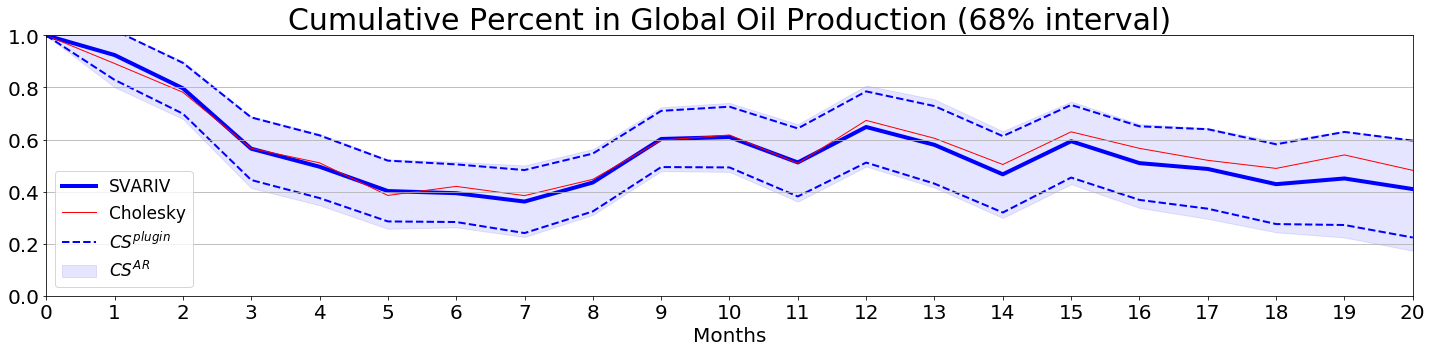

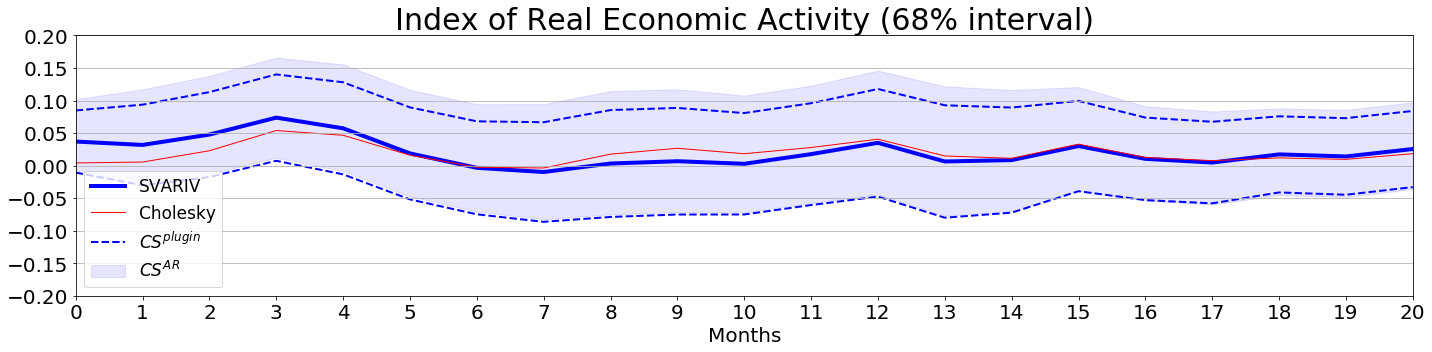

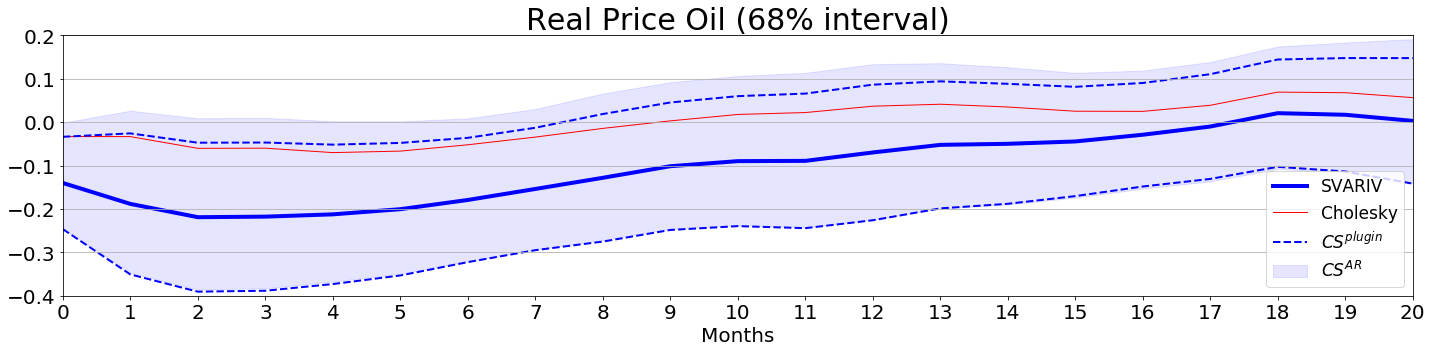

In [14]:
# plugin CS figure 1.1 
plugin_cs = np.array([irf_gamma_cum[:,0] + SVARIV.norm_critval(confidence=0.68)*CI_s_cum['pluginirfstderror'][0,:], 
                      irf_gamma_cum[:,0] - SVARIV.norm_critval(confidence=0.68)*CI_s_cum['pluginirfstderror'][0,:]]).T
fig11 = SVARIV.simple_plot('Cumulative Percent in Global Oil Production (68% interval)', 
                          irf_gamma_cum[:,0], irf_chol_cum[:,0], 
                          CI_cum['l'][0,:], CI_cum['u'][0,:],
                          plugin_cs[:,0], plugin_cs[:,1],
                          list(range(len(irf_gamma_cum))), 
                          '', rot=0, ylim0=0, 
                          ylim1=1, figsize=(20,5))

# figure 1.2
plugin_cs = np.array([irf_gamma[:,1] + SVARIV.norm_critval(confidence=0.68)*CI_s['pluginirfstderror'][1,:], 
                      irf_gamma[:,1] - SVARIV.norm_critval(confidence=0.68)*CI_s['pluginirfstderror'][1,:]]).T
fig12 = SVARIV.simple_plot('Index of Real Economic Activity (68% interval)', 
                          irf_gamma[:,1], irf_chol[:,1],
                          CI['l'][1,:], CI['u'][1,:],
                          plugin_cs[:,0], plugin_cs[:,1],
                          list(range(len(irf_gamma_cum))), 
                          '', rot=0, ylim0=-.2, 
                          ylim1=.2, figsize=(20,5))

# figure 1.3
plugin_cs = np.array([irf_gamma[:,2] + SVARIV.norm_critval(confidence=0.68)*CI_s['pluginirfstderror'][2,:], 
                      irf_gamma[:,2] - SVARIV.norm_critval(confidence=0.68)*CI_s['pluginirfstderror'][2,:]]).T
fig13 = SVARIV.simple_plot('Real Price Oil (68% interval)', 
                          irf_gamma[:,2], irf_chol[:,2],
                          CI['l'][2,:], CI['u'][2,:],
                          plugin_cs[:,0], plugin_cs[:,1],
                          list(range(len(irf_gamma_cum))), 
                          '', rot=0, ylim0=-.4, 
                          ylim1=.2, figsize=(20,5))




# Replicate - Figure 2: Impulse response coefficients for an oil-supply shock

## 95% confidence sets

With the estimates and the confidence sets we can create the Figure 2 of the paper.

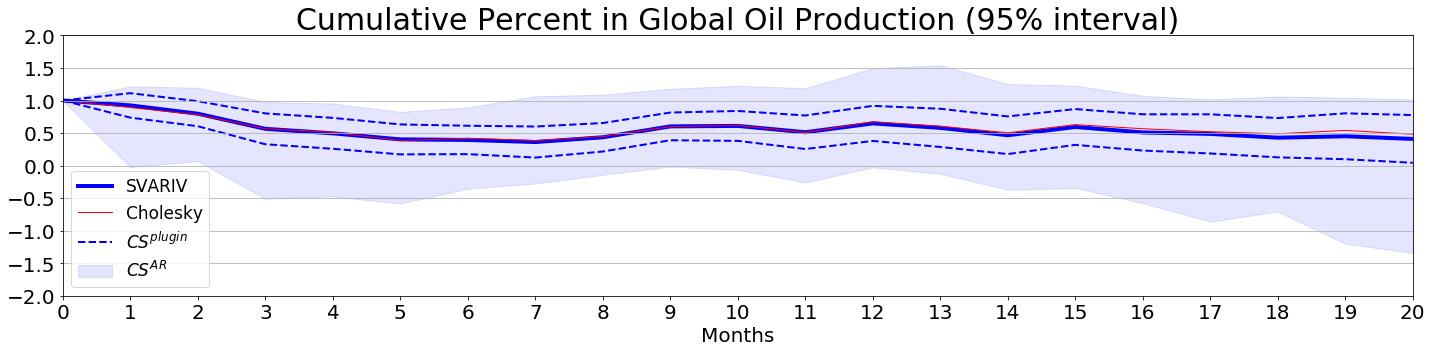

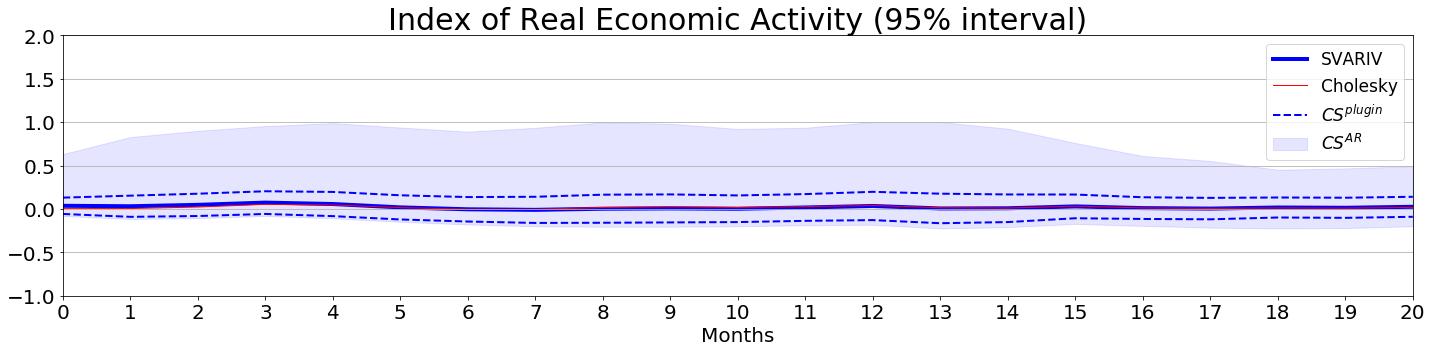

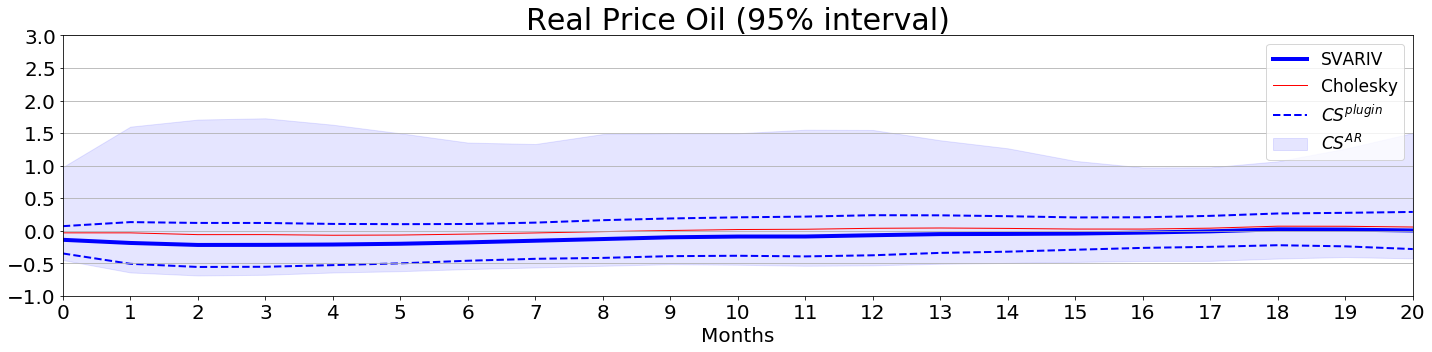

In [15]:
# Confidense sets dmethod
C = SVARIV.MA_representation(betas_lag, p, hori=21)  # MA representation
Ccum = [np.array(C[:i+1]).sum(axis=0) for i in range(len(C))]
G = SVARIV.Gmatrices(betas_lag, p, hori=21)['G'] # Gradient matrix
Gcum = SVARIV.Gmatrices(betas_lag, p, hori=21)['Gcum'] # Gradient matrix cumulative
T = len(Y) # number of obs
CI = SVARIV.CI_dmethod(Gamma_hat, WHat, G, T, C, hori=21, confidence=0.95, scale=1, nvar=1) #CI intervals
CI_cum = SVARIV.CI_dmethod(Gamma_hat, WHat, Gcum, T, Ccum, hori=21, confidence=0.95, scale=1, nvar=1) #CI intervals
CI_s = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, G, T, C)
CI_s_cum = SVARIV.CI_dmethod_standard(Gamma_hat, WHat, Gcum, T, Ccum)


# plugin CS figure 1.1 
plugin_cs = np.array([irf_gamma_cum[:,0] + SVARIV.norm_critval()*CI_s_cum['pluginirfstderror'][0,:], 
                      irf_gamma_cum[:,0] - SVARIV.norm_critval()*CI_s_cum['pluginirfstderror'][0,:]]).T
fig11 = SVARIV.simple_plot('Cumulative Percent in Global Oil Production (95% interval)', 
                          irf_gamma_cum[:,0], irf_chol_cum[:,0], 
                          CI_cum['l'][0,:], CI_cum['u'][0,:],
                          plugin_cs[:,0], plugin_cs[:,1],
                          list(range(len(irf_gamma_cum))), 
                          '', rot=0, ylim0=-2, 
                          ylim1=2, figsize=(20,5))

# figure 1.2
plugin_cs = np.array([irf_gamma[:,1] + SVARIV.norm_critval()*CI_s['pluginirfstderror'][1,:], 
                      irf_gamma[:,1] - SVARIV.norm_critval()*CI_s['pluginirfstderror'][1,:]]).T
fig12 = SVARIV.simple_plot('Index of Real Economic Activity (95% interval)', 
                          irf_gamma[:,1], irf_chol[:,1],
                          CI['l'][1,:], CI['u'][1,:],
                          plugin_cs[:,0], plugin_cs[:,1],
                          list(range(len(irf_gamma_cum))), 
                          '', rot=0, ylim0=-1, 
                          ylim1=2, figsize=(20,5))

# figure 1.3
plugin_cs = np.array([irf_gamma[:,2] + SVARIV.norm_critval()*CI_s['pluginirfstderror'][2,:], 
                      irf_gamma[:,2] - SVARIV.norm_critval()*CI_s['pluginirfstderror'][2,:]]).T
fig13 = SVARIV.simple_plot('Real Price Oil (95% interval)', 
                          irf_gamma[:,2], irf_chol[:,2],
                          CI['l'][2,:], CI['u'][2,:],
                          plugin_cs[:,0], plugin_cs[:,1],
                          list(range(len(irf_gamma_cum))), 
                          '', rot=0, ylim0=-1, 
                          ylim1=3, figsize=(20,5))
